In [99]:
import os
import time
import numpy as np
import pandas as pd

from radar_object_tracking.radarprocessing.radar_fd_textdata_parser import read_columns

directory_to_process = "data/radar/run5-FD"
fd_data = []

def process_data_from_folder(self):
        
        # List all files in the directory
        files = os.listdir(directory_to_process)
        
        # Filter the files based on the naming convention
        txt_files = [f for f in files if f.startswith('trial') and f.endswith('.txt')]
        
        # Sort the files if needed (optional)
        txt_files.sort()
        
        # Process each file one by one
        for file_name in txt_files:
            file_path = os.path.join(directory_to_process, file_name)
            
            # print(f"Processing file: {file_path}")
            new_fd_data = read_columns(file_path)
            fd_data.append(new_fd_data.fd_data)

In [100]:
process_data_from_folder(directory_to_process)
fd_data = np.array(fd_data)

I1_data = fd_data[:, :, 0]  # Extract the I1 signal, which is the first column across all frames and range bins  # Extract the first column, which corresponds to I1



In [101]:
print(fd_data.shape)

(1023, 513, 8)


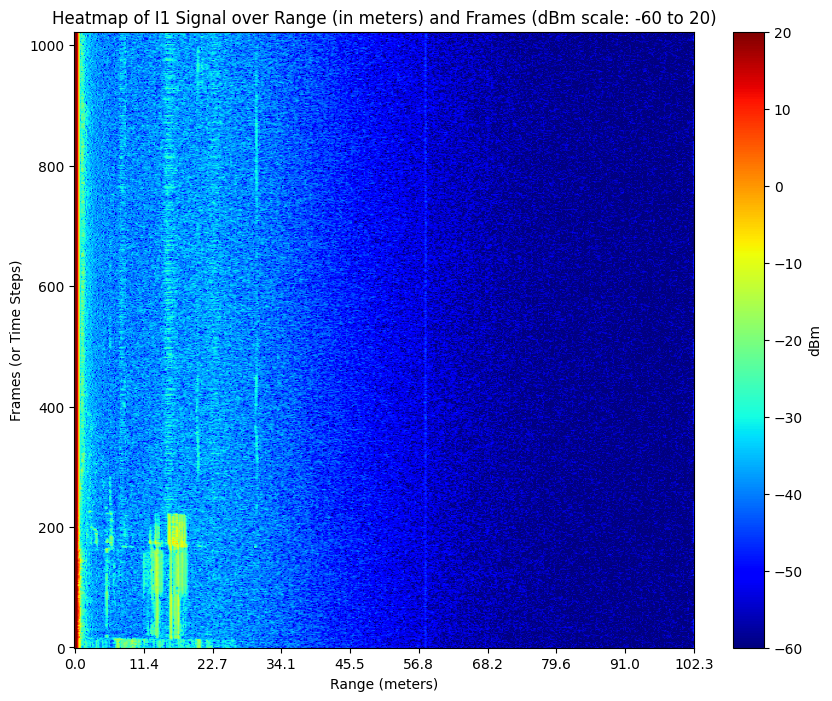

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 0.2 meters per range bin
range_bin_resolution = 0.199861  # in meters

# Calculate the actual range bin distances (indices multiplied by range resolution)
range_bin_distances = np.arange(I1_data.shape[1]) * range_bin_resolution  # Shape[1] is the number of range bins (512) #viridis

plt.figure(figsize=(10, 8))

# Plot the heatmap with the dBm scale from -60 to 20
plt.imshow(I1_data, aspect='auto', cmap='jet', vmin=-60, vmax=20)

# Add a colorbar with a label
plt.colorbar(label='dBm')

# Set the x-axis labels to be the actual distances
plt.xticks(ticks=np.linspace(0, I1_data.shape[1] - 1, num=10),  # Choose 10 ticks for readability
           labels=np.round(np.linspace(range_bin_distances[0], range_bin_distances[-1], num=10), 1))  # Rounded to 1 decimal

# Set labels for the axes
plt.xlabel('Range (meters)')
plt.ylabel('Frames (or Time Steps)')

# Reverse the direction of the y-axis
plt.gca().invert_yaxis()

# Optional: Set a title
plt.title('Heatmap of I1 Signal over Range (in meters) and Frames (dBm scale: -60 to 20)')

# Show the plot
plt.show()




In [103]:
import numpy as np

def moving_average(data, window_size):
    """Apply a moving average to each column of the 2D array."""
    return np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size) / window_size, mode='same'), axis=0, arr=data)

# Choose a window size for the moving average (larger = more smoothing)
window_size = 4

# Apply the moving average across each range bin (column) of I1_data
I1_data_smoothed = moving_average(I1_data, window_size)


In [104]:
from scipy.ndimage import gaussian_filter1d

# Apply Gaussian smoothing to each range bin (column) of I1_data
sigma = 1  # Standard deviation for Gaussian kernel (higher = more smoothing)
I1_data_smoothed_gaussian = gaussian_filter1d(I1_data, sigma=sigma, axis=0)  # Smooth along frames (axis=0)

In [105]:
import matplotlib.pyplot as plt
import numpy as np

def plot_I1_heatmap(I1_data, range_bin_resolution=0.2, max_range=50, vmin=-60, vmax=20, title='Heatmap of I1 Signal'):
    """
    Plots a heatmap of the I1 signal over range bins and frames, with y-axis running from 0 to maximum.

    Parameters:
    I1_data (2D array): The I1 data to plot (frames x range bins).
    range_bin_resolution (float): The resolution of range bins in meters.
    max_range (float): The maximum range (in meters) to plot.
    vmin (float): Minimum dBm value for color scale.
    vmax (float): Maximum dBm value for color scale.
    title (str): Title for the plot.
    """
    # Calculate the actual range bin distances
    range_bin_distances = np.arange(I1_data.shape[1]) * range_bin_resolution
    
    # Find the index where the range exceeds the maximum range
    max_range_index = np.where(range_bin_distances > max_range)[0][0]

    # Slice the data up to the desired maximum range
    range_bin_distances = range_bin_distances[:max_range_index]
    I1_data_sliced = I1_data[:, :max_range_index]  # Slice the I1 data accordingly
    frames = np.arange(I1_data.shape[0])  # Shape[0] is the number of frames (rows)

    plt.figure(figsize=(10, 8))

    # Use pcolormesh to create a heatmap-like grid without blending
    plt.pcolormesh(range_bin_distances, frames, I1_data_sliced, cmap='jet', vmin=vmin, vmax=vmax, shading='auto')

    # Add a colorbar with a label
    plt.colorbar(label='dBm')

    # Set the x-axis labels to be the actual distances
    plt.xlabel('Range (meters)')
    plt.ylabel('Frames (or Time Steps)')

    # No need to invert the y-axis; let it go naturally from 0 at the top
    # plt.gca().invert_yaxis() -> Remove this line

    # Set the title
    plt.title(title)

    # Show the plot
    plt.show()



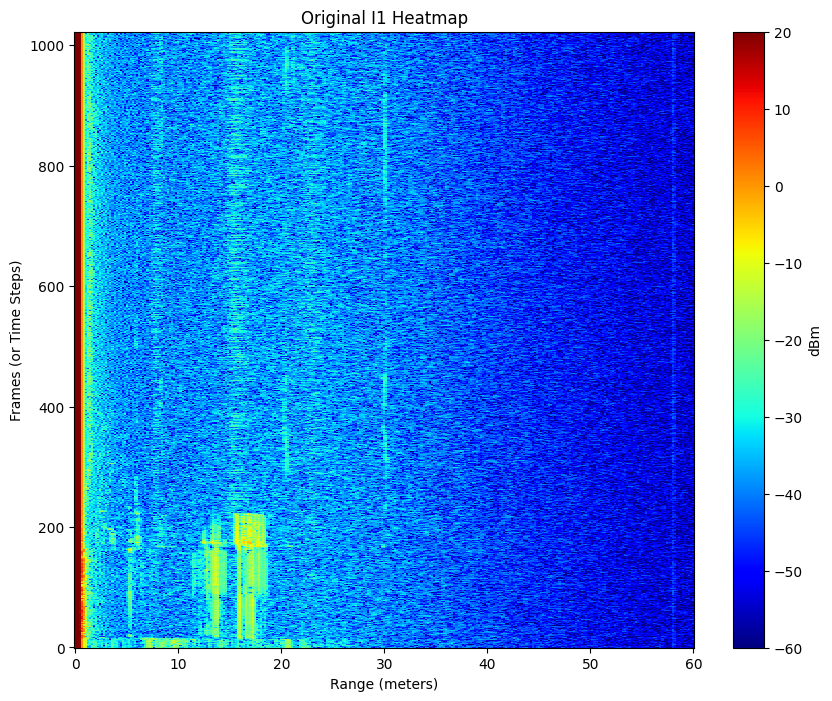

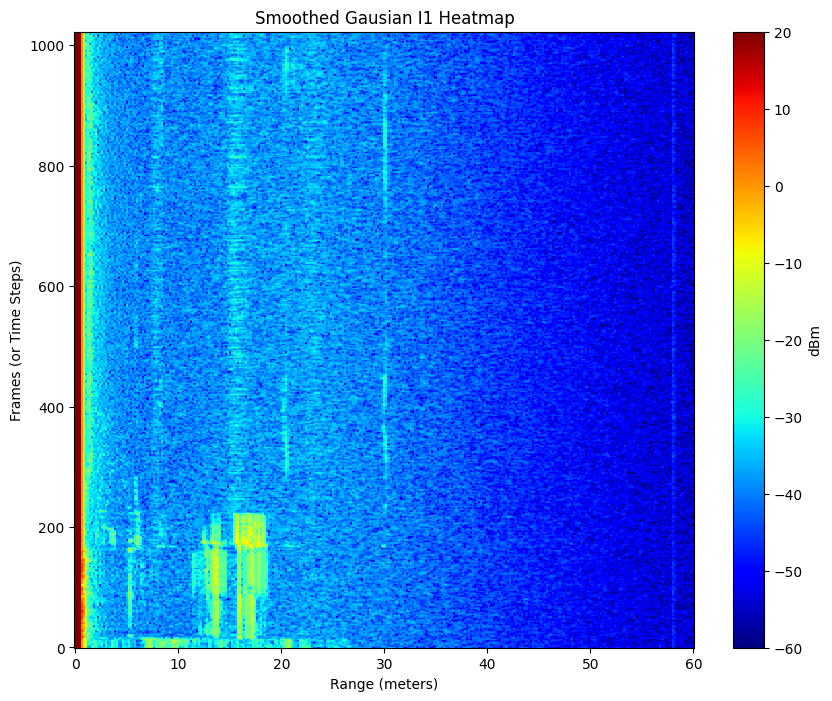

In [106]:
plot_I1_heatmap(I1_data, range_bin_resolution=0.2, max_range=60, title='Original I1 Heatmap')
# plot_I1_heatmap(I1_data_smoothed, range_bin_resolution=0.2, max_range=50, title='Smoothed I1 Heatmap')
plot_I1_heatmap(I1_data_smoothed_gaussian, range_bin_resolution=0.2, max_range=60, title='Smoothed Gausian I1 Heatmap')



In [107]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rx1_signal_power(fd_data, range_bin_resolution=0.2, max_range=50, vmin=0, vmax=80, title='Heatmap of Rx1 Signal Power'):
    """
    Plots a heatmap of the Rx1 signal power (magnitude of I1 and Q1) over range bins and frames.

    Parameters:
    fd_data (2D array): The data containing I1 and Q1 signals (frames x range bins x 8).
    range_bin_resolution (float): The resolution of range bins in meters.
    max_range (float): The maximum range (in meters) to plot.
    vmin (float): Minimum dBm value for color scale.
    vmax (float): Maximum dBm value for color scale.
    title (str): Title for the plot.
    """
    # Extract the I1 and Q1 signals
    I1_data = fd_data[:, :, 0]  # I1 is the first signal
    Q1_data = fd_data[:, :, 1]  # Q1 is the second signal

    # Compute the signal power (magnitude of I1 and Q1)
    signal_power = np.sqrt(I1_data**2 + Q1_data**2)

    # Calculate the actual range bin distances
    range_bin_distances = np.arange(signal_power.shape[1]) * range_bin_resolution
    
    # Find the index where the range exceeds the maximum range
    max_range_index = np.where(range_bin_distances > max_range)[0][0]

    # Slice the data up to the desired maximum range
    range_bin_distances = range_bin_distances[:max_range_index]
    signal_power_sliced = signal_power[:, :max_range_index]  # Slice the signal power accordingly
    frames = np.arange(signal_power.shape[0])  # Shape[0] is the number of frames (rows)

    plt.figure(figsize=(10, 8))

    # Use pcolormesh to create a heatmap-like grid without blending
    plt.pcolormesh(range_bin_distances, frames, signal_power_sliced, cmap='jet', vmin=vmin, vmax=vmax, shading='auto')

    # Add a colorbar with a label
    plt.colorbar(label='Signal Power (dBm)')

    # Set the x-axis labels to be the actual distances
    plt.xlabel('Range (meters)')
    plt.ylabel('Frames (or Time Steps)')

    # Set the title
    plt.title(title)

    # Show the plot
    plt.show()



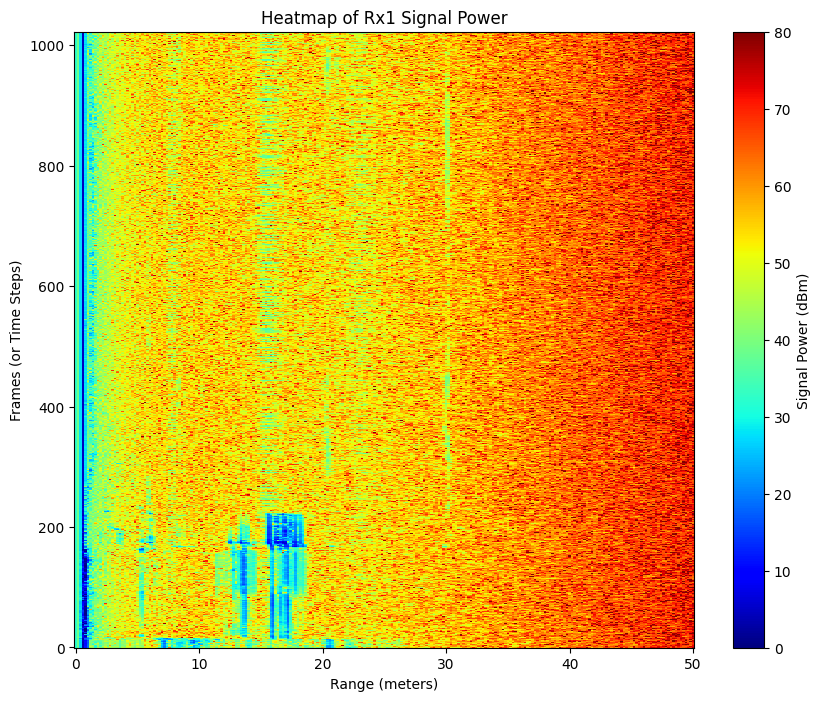

In [108]:
# Assuming fd_data is your data with shape (343, 512, 8), containing I1 and Q1 signals
plot_rx1_signal_power(fd_data, range_bin_resolution=0.2, max_range=50, title='Heatmap of Rx1 Signal Power')


In [109]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

def plot_rx1_signal_power(fd_data, range_bin_resolution=0.2, max_range=50, vmin=0, vmax=60, sigma=1, title='Heatmap of Rx1 Signal Power (Smoothed)'):
    """
    Plots a heatmap of the Rx1 signal power (magnitude of I1 and Q1) over range bins and frames with Gaussian smoothing.

    Parameters:
    fd_data (2D array): The data containing I1 and Q1 signals (frames x range bins x 8).
    range_bin_resolution (float): The resolution of range bins in meters.
    max_range (float): The maximum range (in meters) to plot.
    vmin (float): Minimum dBm value for color scale.
    vmax (float): Maximum dBm value for color scale.
    sigma (float): Standard deviation for Gaussian kernel (higher = more smoothing).
    title (str): Title for the plot.
    """
    # Extract the I1 and Q1 signals
    I1_data = fd_data[:, :, 0]  # I1 is the first signal
    Q1_data = fd_data[:, :, 1]  # Q1 is the third signal

    # Compute the signal power (magnitude of I1 and Q1)
    signal_power = np.sqrt(I1_data**2 + Q1_data**2)

    # Apply Gaussian smoothing to each range bin (column) of the signal power
    signal_power_smoothed = gaussian_filter1d(signal_power, sigma=sigma, axis=0)

    # Calculate the actual range bin distances
    range_bin_distances = np.arange(signal_power.shape[1]) * range_bin_resolution
    
    # Find the index where the range exceeds the maximum range
    max_range_index = np.where(range_bin_distances > max_range)[0][0]

    # Slice the data up to the desired maximum range
    range_bin_distances = range_bin_distances[:max_range_index]
    signal_power_sliced = signal_power_smoothed[:, :max_range_index]  # Slice the smoothed signal power accordingly
    frames = np.arange(signal_power.shape[0])  # Shape[0] is the number of frames (rows)

    plt.figure(figsize=(10, 8))

    # Use pcolormesh to create a heatmap-like grid without blending
    plt.pcolormesh(range_bin_distances, frames, signal_power_sliced, cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')

    # Add a colorbar with a label
    plt.colorbar(label='Signal Power (dBm)')

    # Set the x-axis labels to be the actual distances
    plt.xlabel('Range (meters)')
    plt.ylabel('Frames (or Time Steps)')

    # Set the title
    plt.title(title)

    # Show the plot
    plt.show()


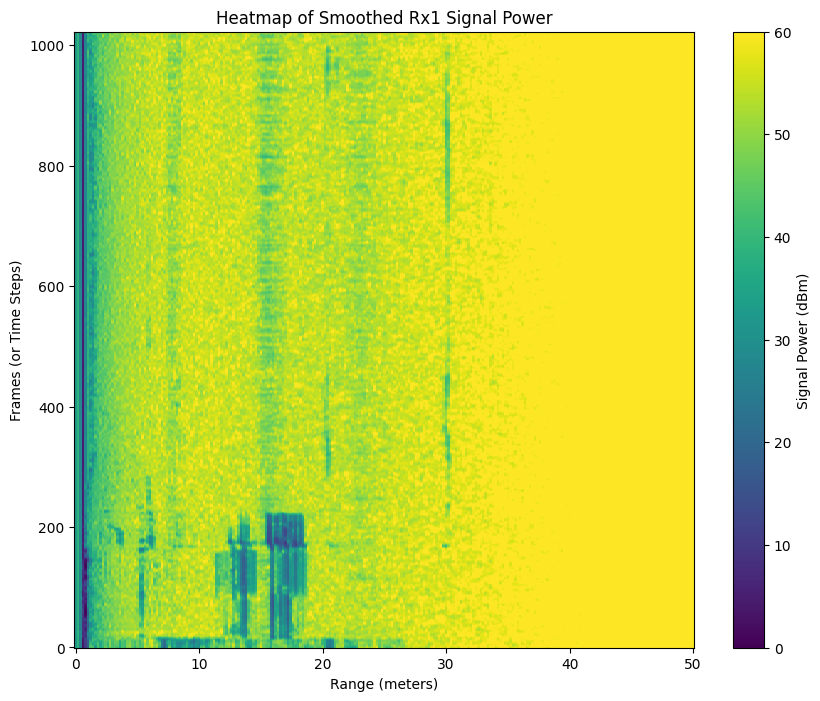

In [110]:
# Assuming fd_data is your data with shape (343, 512, 8), containing I1 and Q1 signals

# Plot Rx1 signal power with Gaussian smoothing
plot_rx1_signal_power(fd_data, range_bin_resolution=0.2, max_range=50, sigma=2, title='Heatmap of Smoothed Rx1 Signal Power')


In [111]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_rx1_signal_power(fd_data):
    """
    Calculates the signal power of Rx1 from I1 and Q1 components.

    Parameters:
    fd_data (3D array): The data containing I1, Q1, I2, Q2 signals (range bins x signal components).

    Returns:
    np.ndarray: Signal power for Rx1.
    """
    I1 = fd_data[:, :, 0]  # I1 signal
    Q1 = fd_data[:, :, 1]  # Q1 signal
    
    # Calculate the signal power for Rx1
    signal_power = np.sqrt(I1**2 + Q1**2)
    return signal_power

def calculate_rx2_signal_power(fd_data):
    """
    Calculates the signal power of Rx2 from I2 and Q2 components.

    Parameters:
    fd_data (3D array): The data containing I1, I1_phase Q1, Q1_phase, I2, I2_phase, Q2, Q2_phase signals (range bins x signal components).

    Returns:
    np.ndarray: Signal power for Rx1.
    """
    I2 = fd_data[:, :, 2]  # I2 signal
    Q2 = fd_data[:, :, 3]  # Q2 signal
    
    # Calculate the signal power for Rx1
    signal_power = np.sqrt(I2**2 + Q2**2)
    return signal_power

def ca_cfar(signal_power, num_training=10, num_guard=5, threshold=10):
    """
    Applies CA-CFAR to the given signal power data.

    Parameters:
    signal_power (2D array): The signal power data (time x range bins).
    num_training (int): Number of training cells on each side.
    num_guard (int): Number of guard cells on each side.
    threshold (float): Threshold in dBm.

    Returns:
    np.ndarray: CA-CFAR detection result as a binary matrix.
    """
    num_bins = signal_power.shape[1]  # Number of range bins
    num_samples = signal_power.shape[0]  # Number of time samples
    
    # Initialize a matrix to hold the CFAR detection result
    cfar_result = np.zeros(signal_power.shape)
    
    # Convert threshold from dBm to linear scale
    threshold_linear = 10**(threshold / 10)
    
    # Loop through each range bin and time sample, applying CA-CFAR
    for t in range(num_samples):
        for i in range(num_training + num_guard, num_bins - (num_training + num_guard)):
            # Calculate the noise level using training cells
            leading_noise = np.sum(signal_power[t, i - num_training - num_guard : i - num_guard])
            lagging_noise = np.sum(signal_power[t, i + num_guard + 1 : i + num_guard + 1 + num_training])
            total_noise = (leading_noise + lagging_noise) / (2 * num_training)
            
            # Compare the signal power of the CUT (cell under test) to the threshold
            if signal_power[t, i] > total_noise * threshold_linear:
                cfar_result[t, i] = 1  # Detection
    
    return cfar_result

def caso_cfar(signal_power, num_training=10, num_guard=5, threshold=10):
    """
    Applies CASO-CFAR (Cell Averaging Smallest Of CFAR) to the given signal power data.

    Parameters:
    signal_power (2D array): The signal power data (time x range bins).
    num_training (int): Number of training cells on each side.
    num_guard (int): Number of guard cells on each side.
    threshold (float): Threshold in dBm.

    Returns:
    np.ndarray: CASO-CFAR detection result as a binary matrix.
    """
    num_bins = signal_power.shape[1]  # Number of range bins
    num_samples = signal_power.shape[0]  # Number of time samples
    
    # Initialize a matrix to hold the CFAR detection result
    cfar_result = np.zeros(signal_power.shape)
    
    # Convert threshold from dBm to linear scale
    threshold_linear = 10**(threshold / 10)
    
    # Loop through each range bin and time sample, applying CASO-CFAR
    for t in range(num_samples):
        for i in range(num_training + num_guard, num_bins - (num_training + num_guard)):
            # Calculate the noise level using leading and lagging training cells
            leading_noise = np.sum(signal_power[t, i - num_training - num_guard : i - num_guard])
            lagging_noise = np.sum(signal_power[t, i + num_guard + 1 : i + num_guard + 1 + num_training])
            
            # Use the smallest noise estimate
            total_noise = min(leading_noise, lagging_noise) / num_training
            
            # Compare the signal power of the CUT (cell under test) to the threshold
            if signal_power[t, i] > total_noise * threshold_linear:
                cfar_result[t, i] = 1  # Detection
    
    return cfar_result


def plot_cfar_heatmap(cfar_result, range_bin_resolution=0.2, num_range_bins=512, title='CA-CFAR Detection Heatmap'):
    """
    Plots a heatmap for the CA-CFAR detection result.

    Parameters:
    cfar_result (np.ndarray): CA-CFAR detection result as a binary matrix.
    range_bin_resolution (float): The resolution of range bins in meters.
    num_range_bins (int): Number of range bins.
    title (str): Title of the heatmap.
    """
    # Calculate the actual range bin distances (for the x-axis)
    range_bin_distances = np.arange(num_range_bins) * range_bin_resolution

    # Plot the CFAR detection result as a heatmap
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(range_bin_distances, np.arange(cfar_result.shape[0]), cfar_result, cmap='hot', shading='auto')

    # Add colorbar and labels
    plt.colorbar(label='Detection (1 = Detected)')
    plt.xlabel('Range (meters)')
    plt.ylabel('Time Samples')
    plt.title(title)

    # Show the plot
    plt.show()


In [112]:
def caso_cfar_time(signal_power, num_training=10, num_guard=5, threshold=10):
    """
    Applies CASO-CFAR (Cell Averaging Smallest Of CFAR) across time for each range bin.

    Parameters:
    signal_power (2D array): The signal power data (time x range bins).
    num_training (int): Number of training cells on each side.
    num_guard (int): Number of guard cells on each side.
    threshold (float): Threshold in dBm.

    Returns:
    np.ndarray: CASO-CFAR detection result as a binary matrix.
    """
    num_bins = signal_power.shape[1]  # Number of range bins
    num_samples = signal_power.shape[0]  # Number of time samples
    
    # Initialize a matrix to hold the CFAR detection result
    cfar_result = np.zeros(signal_power.shape)
    
    # Convert threshold from dBm to linear scale
    threshold_linear = 10**(threshold / 10)
    
    # Loop through each range bin and apply CASO-CFAR across time (vertically)
    for i in range(num_bins):
        for t in range(num_training + num_guard, num_samples - (num_training + num_guard)):
            # Calculate the noise level using leading and lagging training cells along the time axis
            leading_noise = np.sum(signal_power[t - num_training - num_guard : t - num_guard, i])
            lagging_noise = np.sum(signal_power[t + num_guard + 1 : t + num_guard + 1 + num_training, i])
            
            # Use the smallest noise estimate
            total_noise = min(leading_noise, lagging_noise) / num_training
            
            # Compare the signal power of the CUT (cell under test) to the threshold
            if signal_power[t, i] > total_noise * threshold_linear:
                cfar_result[t, i] = 1  # Detection
    
    return cfar_result



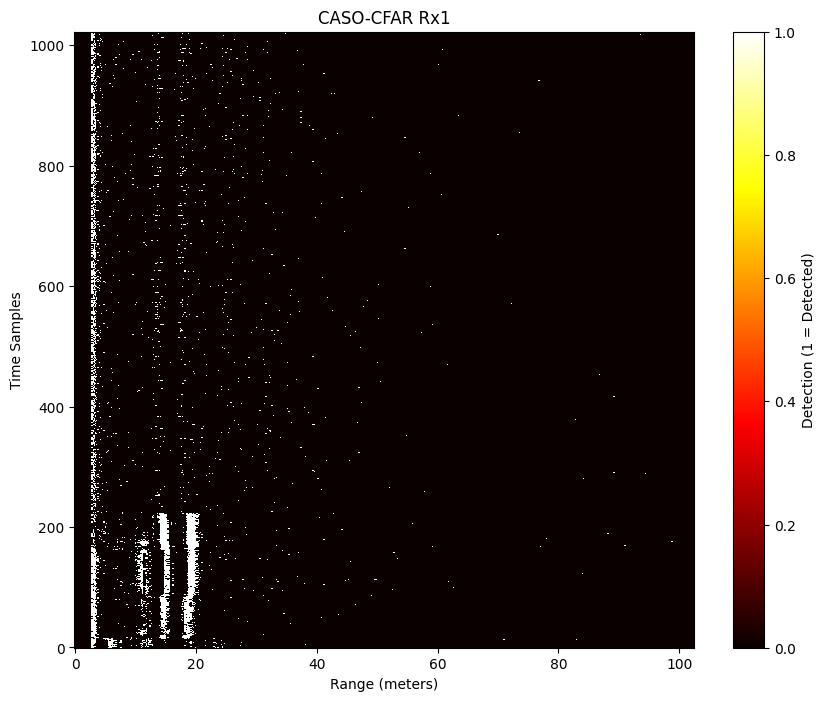

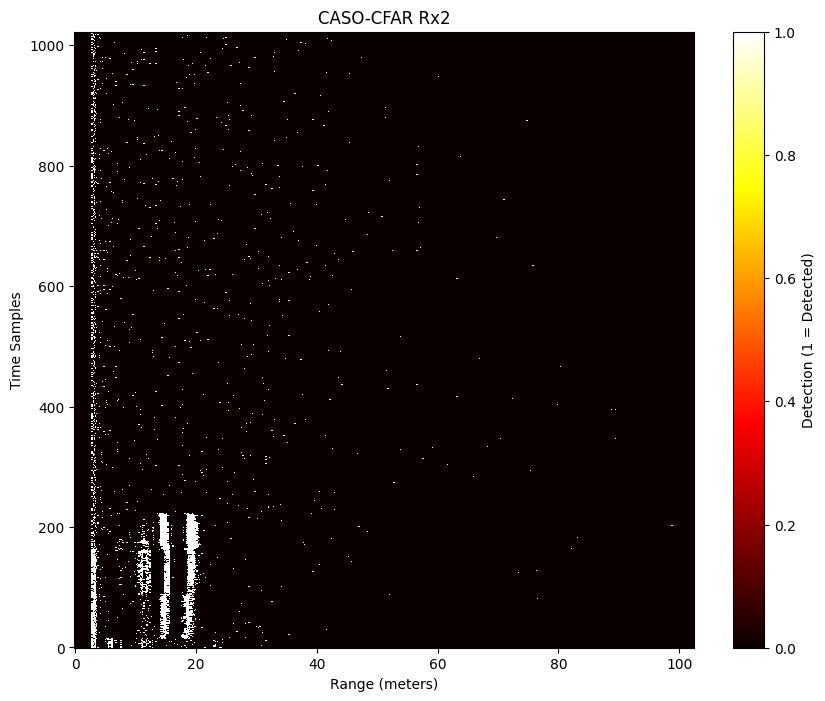

In [113]:
num_training = 10
num_guard = 4
threshold = 1.5

# Calculate the signal power for Rx1
signal_power_rx1= calculate_rx1_signal_power(fd_data)
signal_power_rx2= calculate_rx2_signal_power(fd_data)

# Apply CA-CFAR with a sliding window of 10, guard cells of 5, and threshold of 10 dBm
# cfar_result_rx1 = ca_cfar(signal_power_rx1, num_training=num_training, num_guard=num_guard, threshold=threshold)
cfar_result_rx1 = caso_cfar(signal_power_rx1, num_training=num_training, num_guard=num_guard, threshold=threshold)
cfar_result_rx2 = caso_cfar(signal_power_rx2, num_training=num_training, num_guard=num_guard, threshold=threshold)

# Plot the CA-CFAR detection result as a heatmap
plot_cfar_heatmap(cfar_result_rx1, range_bin_resolution=0.2, num_range_bins=513,title='CASO-CFAR Rx1')
plot_cfar_heatmap(cfar_result_rx2, range_bin_resolution=0.2, num_range_bins=513, title='CASO-CFAR Rx2')


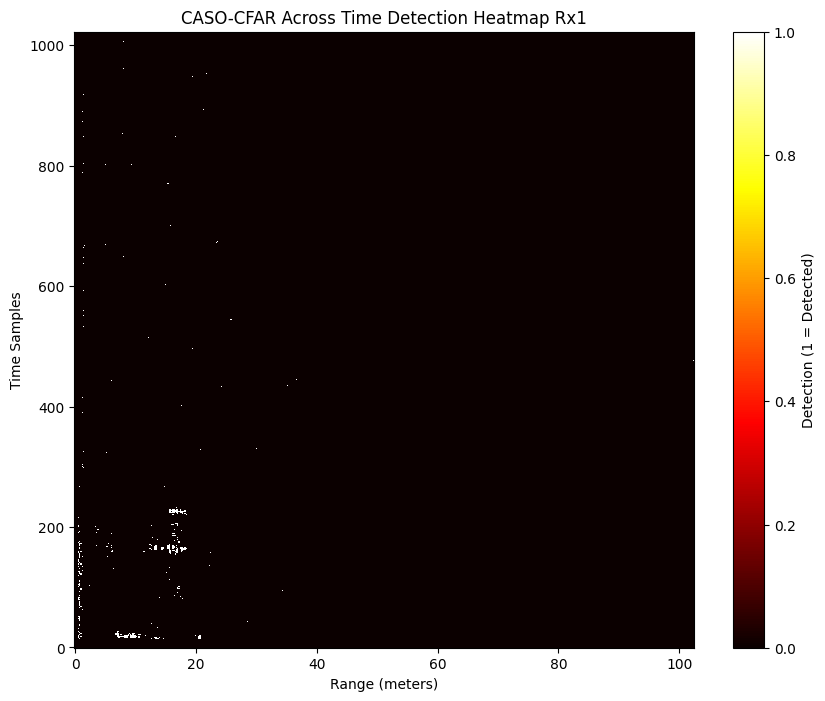

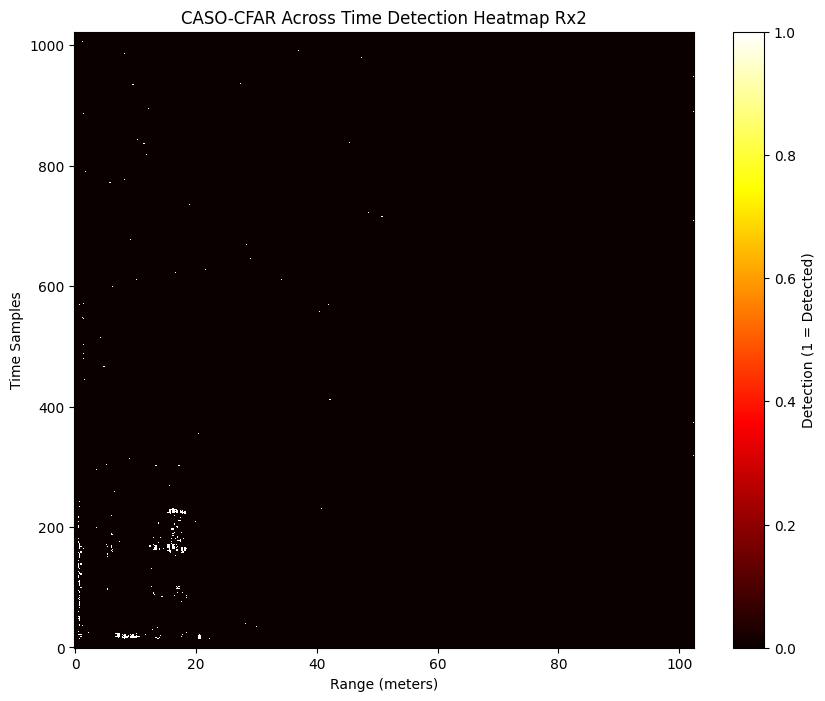

In [114]:
# Example usage for CASO-CFAR across time

num_training_time = 12
num_guard_time = 3
threshold_time = 2

# Calculate the signal power for Rx1
signal_power_rx1_time = calculate_rx1_signal_power(fd_data)
signal_power_rx2_time = calculate_rx2_signal_power(fd_data)

# Apply CASO-CFAR across time with a sliding window of 10, guard cells of 5, and threshold of 10 dBm
caso_cfar_time_result_rx1 = caso_cfar_time(signal_power_rx1_time, num_training=num_training_time, num_guard=num_guard_time, threshold=threshold_time)
caso_cfar_time_result_rx2 = caso_cfar_time(signal_power_rx2_time, num_training=num_training_time, num_guard=num_guard_time, threshold=threshold_time)

# Plot the CASO-CFAR detection result as a heatmap
plot_cfar_heatmap(caso_cfar_time_result_rx1, range_bin_resolution=0.2, num_range_bins=513, title='CASO-CFAR Across Time Detection Heatmap Rx1')
plot_cfar_heatmap(caso_cfar_time_result_rx2, range_bin_resolution=0.2, num_range_bins=513, title='CASO-CFAR Across Time Detection Heatmap Rx2')

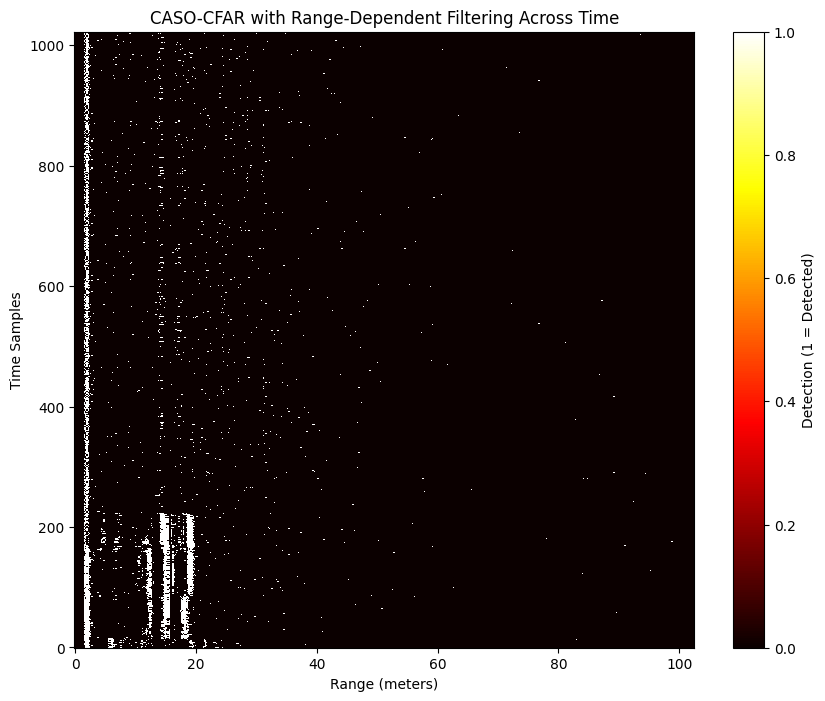

In [115]:
from scipy.ndimage import gaussian_filter

def caso_cfar_with_time_range_filtering(signal_power, num_training=10, num_guard=5, base_threshold=10, range_factor=1.5):
    """
    Applies CASO-CFAR (Cell Averaging Smallest Of CFAR) across time for each range bin, with range-dependent filtering
    across all bins for each time range.

    Parameters:
    signal_power (2D array): The signal power data (time x range bins).
    num_training (int): Number of training cells on each side.
    num_guard (int): Number of guard cells on each side.
    base_threshold (float): Base threshold in dBm.
    range_factor (float): Factor to increase the threshold for lower range bins.

    Returns:
    np.ndarray: CASO-CFAR detection result as a binary matrix.
    """
    num_bins = signal_power.shape[1]  # Number of range bins
    num_samples = signal_power.shape[0]  # Number of time samples
    
    # Initialize a matrix to hold the CFAR detection result
    cfar_result = np.zeros(signal_power.shape)
    
    # Loop through each time sample and apply CASO-CFAR across the range bins
    for t in range(num_samples):
        # Loop through range bins, applying the range-dependent threshold
        for i in range(num_training + num_guard, num_bins - (num_training + num_guard)):
            # Apply range-dependent scaling: increase the threshold for lower range bins
            range_scaled_threshold = base_threshold + range_factor / (i + 1)
            threshold_linear = 10**(range_scaled_threshold / 10)
            
            # Calculate the noise level using leading and lagging training cells for the current range bin
            leading_noise = np.sum(signal_power[t, i - num_training - num_guard : i - num_guard])
            lagging_noise = np.sum(signal_power[t, i + num_guard + 1 : i + num_guard + 1 + num_training])
            
            # Use the smallest noise estimate
            total_noise = min(leading_noise, lagging_noise) / num_training
            
            # Compare the signal power of the CUT (cell under test) to the range-scaled threshold
            if signal_power[t, i] > total_noise * threshold_linear:
                cfar_result[t, i] = 1  # Detection
    
    return cfar_result

def apply_gaussian_smoothing(signal_power, sigma=1):
    """
    Applies Gaussian smoothing to the signal power data.

    Parameters:
    signal_power (2D array): The signal power data (time x range bins).
    sigma (float): Standard deviation for Gaussian kernel.

    Returns:
    np.ndarray: Smoothed signal power.
    """
    smoothed_signal = gaussian_filter(signal_power, sigma=sigma)
    return smoothed_signal

def caso_cfar_with_limited_range_scaling(signal_power, num_training=10, num_guard=5, base_threshold=10, range_factor=1.5, x_bins=50):
    """
    Applies CASO-CFAR (Cell Averaging Smallest Of CFAR) across time for each range bin, with range-dependent threshold
    scaling only for the first 'x' range bins.

    Parameters:
    signal_power (2D array): The signal power data (time x range bins).
    num_training (int): Number of training cells on each side.
    num_guard (int): Number of guard cells on each side.
    base_threshold (float): Base threshold in dBm.
    range_factor (float): Factor to increase the threshold for lower range bins.
    x_bins (int): Number of range bins to apply the increased threshold.

    Returns:
    np.ndarray: CASO-CFAR detection result as a binary matrix.
    """
    num_bins = signal_power.shape[1]  # Number of range bins
    num_samples = signal_power.shape[0]  # Number of time samples
    
    # Initialize a matrix to hold the CFAR detection result
    cfar_result = np.zeros(signal_power.shape)
    
    # Loop through each time sample and apply CASO-CFAR across the range bins
    for t in range(num_samples):
        # Loop through range bins, applying the range-dependent threshold
        for i in range(num_training + num_guard, num_bins - (num_training + num_guard)):
            if i < x_bins:
                # Apply range-dependent scaling for the first 'x' bins
                range_scaled_threshold = base_threshold + range_factor / (i + 1)
                threshold_linear = 10**(range_scaled_threshold / 10)
            else:
                # Use base threshold for bins after 'x' range bins
                threshold_linear = 10**(base_threshold / 10)
            # print(threshold_linear)
            
            # Calculate the noise level using leading and lagging training cells for the current range bin
            leading_noise = np.sum(signal_power[t, i - num_training - num_guard : i - num_guard])
            lagging_noise = np.sum(signal_power[t, i + num_guard + 1 : i + num_guard + 1 + num_training])
            
            # Use the smallest noise estimate
            total_noise = min(leading_noise, lagging_noise) / num_training
            
            # Compare the signal power of the CUT (cell under test) to the threshold
            if signal_power[t, i] > total_noise * threshold_linear:
                cfar_result[t, i] = 1  # Detection
    
    return cfar_result

def os_cfar_time(signal_power, num_training=10, num_guard=5, base_threshold=10, range_factor=1.5, k_order=None):
    """
    Applies OS-CFAR (Ordered Statistics CFAR) across time for each range bin, with range-dependent filtering.

    Parameters:
    signal_power (2D array): The signal power data (time x range bins).
    num_training (int): Number of training cells on each side.
    num_guard (int): Number of guard cells on each side.
    base_threshold (float): Base threshold in dBm.
    range_factor (float): Factor to increase the threshold for lower range bins.
    k_order (int): The index for ordered statistics. Defaults to median.

    Returns:
    np.ndarray: OS-CFAR detection result as a binary matrix.
    """
    num_bins = signal_power.shape[1]  # Number of range bins
    num_samples = signal_power.shape[0]  # Number of time samples
    if k_order is None:
        k_order = num_training  # Use the median as the default
    
    # Initialize a matrix to hold the CFAR detection result
    cfar_result = np.zeros(signal_power.shape)
    
    # Loop through each time sample and apply OS-CFAR across the range bins
    for t in range(num_samples):
        # Loop through range bins, applying the range-dependent threshold
        for i in range(num_training + num_guard, num_bins - (num_training + num_guard)):
            # Apply range-dependent scaling: increase the threshold for lower range bins
            range_scaled_threshold = base_threshold + range_factor / (i + 1)
            threshold_linear = 10**(range_scaled_threshold / 10)
            
            # Collect leading and lagging noise values
            leading_noise = signal_power[t, i - num_training - num_guard : i - num_guard]
            lagging_noise = signal_power[t, i + num_guard + 1 : i + num_guard + 1 + num_training]
            
            # Concatenate the noise samples
            total_noise_samples = np.concatenate([leading_noise, lagging_noise])
            
            # Sort the noise samples and take the k-th ordered statistic
            total_noise_sorted = np.sort(total_noise_samples)
            total_noise = total_noise_sorted[k_order - 1]
            
            # Compare the signal power of the CUT (cell under test) to the range-scaled threshold
            if signal_power[t, i] > total_noise * threshold_linear:
                cfar_result[t, i] = 1  # Detection
    
    return cfar_result



# Step 1: Calculate Rx2 signal power
rx2_signal_power = calculate_rx1_signal_power(fd_data)

# Step 2: Apply CASO-CFAR with range-dependent thresholding across time and range bins

caso_cfar_time_result = caso_cfar_with_time_range_filtering(rx2_signal_power, num_training=5, num_guard=3, base_threshold=1.5, range_factor=4)
# caso_cfar_time_result = os_cfar_time(rx2_signal_power, num_training=5, num_guard=3, base_threshold=1, range_factor=1)

# Step 3: Plot the CASO-CFAR detection result as a heatmap
plot_cfar_heatmap(caso_cfar_time_result, range_bin_resolution=0.2, num_range_bins=513, title='CASO-CFAR with Range-Dependent Filtering Across Time')


(1023, 513)


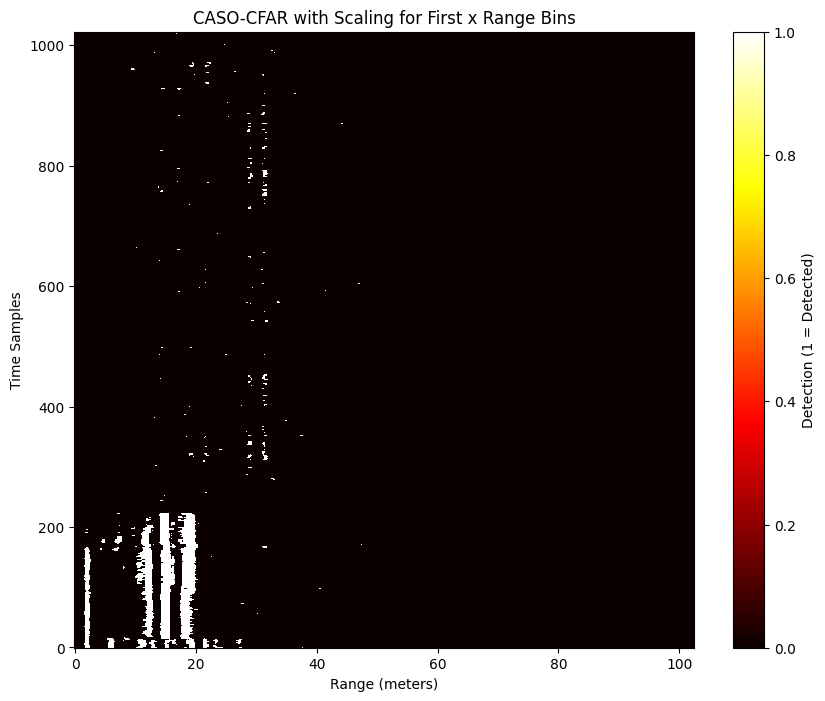

In [120]:
# Step 1: Calculate Rx2 signal power
rx2_signal_power = calculate_rx2_signal_power(fd_data)

# Step 2: Apply Gaussian smoothing to the signal power (optional)
smoothed_signal_power = apply_gaussian_smoothing(rx2_signal_power, sigma=1)

# Step 3: Apply CASO-CFAR with range-dependent scaling for the first 'x' bins
x_bins = 40 # Only increase the threshold for the first 50 range bins
# caso_cfar_time_result = caso_cfar_with_limited_range_scaling(smoothed_signal_power, num_training=5, num_guard=3, base_threshold=0.9, range_factor=20, x_bins=x_bins) # GGOOOODOODODODODOODO DAAAATTTATATATTATATA
caso_cfar_time_result = caso_cfar_with_limited_range_scaling(smoothed_signal_power, num_training=5, num_guard=3, base_threshold=0.6, range_factor=15, x_bins=x_bins)
print(caso_cfar_time_result.shape)

# Step 4: Plot the CASO-CFAR detection result as a heatmap
plot_cfar_heatmap(caso_cfar_time_result, range_bin_resolution=0.2, num_range_bins=513, title='CASO-CFAR with Scaling for First x Range Bins')

# Velocity time 

(1022, 513)


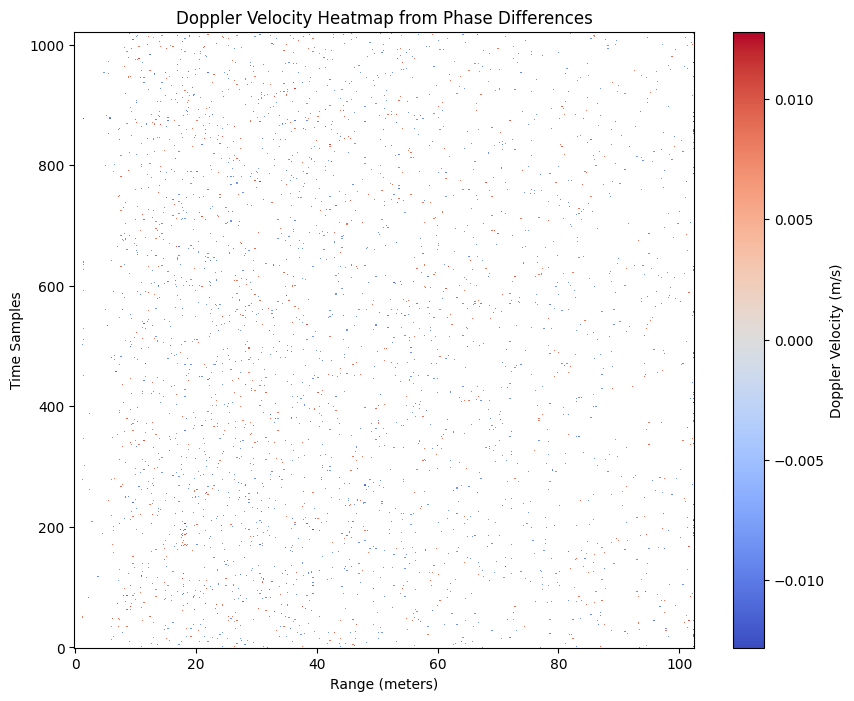

In [117]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_doppler_velocity_from_phases(fd_data, wavelength, sampling_interval):
    """
    Calculates the Doppler velocity based on phase differences between Rx1 and Rx2 over time.

    Parameters:
    fd_data (3D array): The data containing I1, I1_phase, Q1, Q1_phase, I2, I2_phase, Q2, Q2_phase signals 
                        (time samples x range bins x signal components).
    wavelength (float): The radar signal wavelength.
    sampling_interval (float): The time interval between samples (in seconds).

    Returns:
    np.ndarray: Doppler velocity for each range bin (time samples x range bins).
    """
    # Extract Rx1 and Rx2 phases
    rx1_phase = fd_data[:, :, 4]  # Rx1 phase signal
    rx2_phase = fd_data[:, :, 5]  # Rx2 phase signal

    # Calculate phase differences over time (along the time axis)
    rx1_phase_diff = np.diff(rx1_phase, axis=0)
    rx2_phase_diff = np.diff(rx2_phase, axis=0)

    # Calculate average phase difference (can be Rx1 + Rx2 / 2, or take Rx1 alone)
    phase_diff_avg = (rx1_phase_diff + rx2_phase_diff) / 2

    # Doppler velocity formula: v = (Δφ * λ) / (4π * T)
    doppler_velocity = (phase_diff_avg * wavelength) / (4 * np.pi * sampling_interval)

    return doppler_velocity

def plot_doppler_velocity_heatmap(doppler_velocity, range_bin_resolution=0.2, num_range_bins=512, title='Doppler Velocity Heatmap', threshold=0.008):
    """
    Plots a heatmap of the Doppler velocity for each range bin, showing only values above and below a threshold.

    Parameters:
    doppler_velocity (np.ndarray): Doppler velocity array (time samples x range bins).
    range_bin_resolution (float): The resolution of range bins in meters.
    num_range_bins (int): Number of range bins.
    title (str): Title of the heatmap.
    threshold (float): Threshold for displaying velocity values. Values between -threshold and +threshold are masked.
    """
    # Mask the Doppler velocity values that are between -threshold and +threshold
    masked_doppler_velocity = np.copy(doppler_velocity)
    masked_doppler_velocity[(masked_doppler_velocity > -threshold) & (masked_doppler_velocity < threshold)] = np.nan

    # Calculate the actual range bin distances (for the x-axis)
    range_bin_distances = np.arange(num_range_bins) * range_bin_resolution

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(range_bin_distances, np.arange(masked_doppler_velocity.shape[0]), masked_doppler_velocity, cmap='coolwarm', shading='auto')
    
    # Add colorbar and labels
    plt.colorbar(label='Doppler Velocity (m/s)')
    plt.xlabel('Range (meters)')
    plt.ylabel('Time Samples')
    plt.title(title)

    # Show the plot
    plt.show()


# Example usage
wavelength = 0.01233714  # Wavelength for 24.3 GHz signal in meters
sampling_interval = 0.241  # Time interval between samples in seconds

# Step 1: Calculate Doppler velocity from phase differences
doppler_velocity = calculate_doppler_velocity_from_phases(fd_data, wavelength=wavelength, sampling_interval=sampling_interval)
print(doppler_velocity.shape)

# Step 2: Plot the Doppler velocity as a heatmap
plot_doppler_velocity_heatmap(doppler_velocity, range_bin_resolution=0.2, num_range_bins=513, title='Doppler Velocity Heatmap from Phase Differences')


# Combination of Velocity and CFAR

(1022, 513)


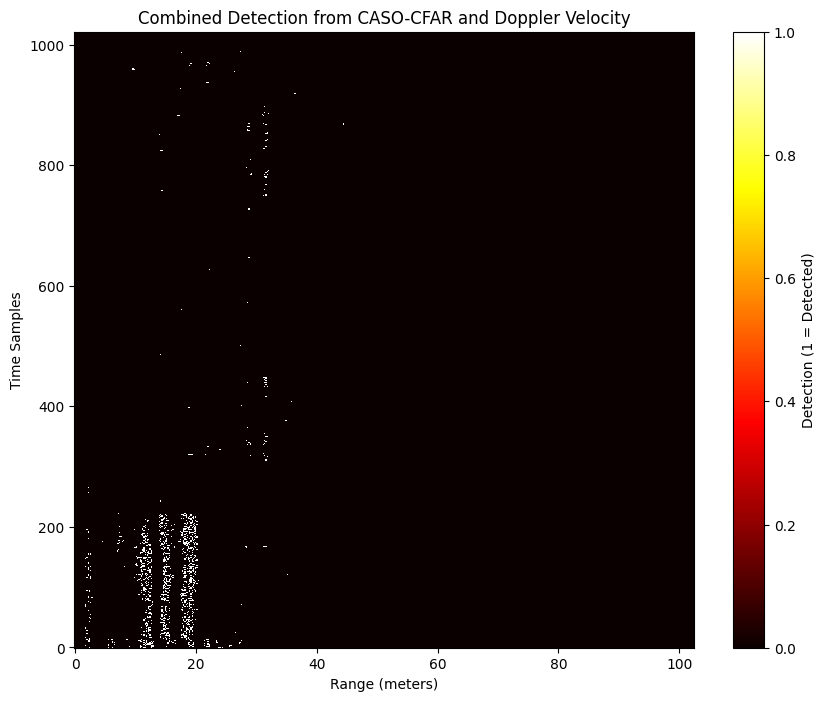

In [118]:
import numpy as np
import matplotlib.pyplot as plt

def combine_cfar_and_doppler(caso_cfar_time_result, doppler_velocity, velocity_threshold):
    """
    Combines CASO-CFAR results and Doppler velocity values to make detections based on both criteria.

    Parameters:
    caso_cfar_time_result (np.ndarray): CASO-CFAR detection result (time x range bins).
    doppler_velocity (np.ndarray): Doppler velocity array (time x range bins).
    velocity_threshold (float): Doppler velocity threshold. Detections occur if |doppler_velocity| > velocity_threshold.

    Returns:
    np.ndarray: Combined detection result as a binary matrix.
    """
    # Create a mask where Doppler velocity exceeds the threshold
    doppler_mask = (doppler_velocity > velocity_threshold) | (doppler_velocity < -velocity_threshold)

    # Combine the doppler mask with the CASO-CFAR result (logical AND)
    combined_detection = doppler_mask & (caso_cfar_time_result == 1)

    return combined_detection

def plot_combined_detection_heatmap(combined_detection, range_bin_resolution=0.2, num_range_bins=513, title='Combined Detection Heatmap'):
    """
    Plots a heatmap for the combined detection result from CASO-CFAR and Doppler velocity.

    Parameters:
    combined_detection (np.ndarray): Combined detection result as a binary matrix.
    range_bin_resolution (float): The resolution of range bins in meters.
    num_range_bins (int): Number of range bins.
    title (str): Title of the heatmap.
    """
    # Calculate the actual range bin distances (for the x-axis)
    range_bin_distances = np.arange(num_range_bins) * range_bin_resolution

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(range_bin_distances, np.arange(combined_detection.shape[0]), combined_detection, cmap='hot', shading='auto')

    # Add colorbar and labels
    plt.colorbar(label='Detection (1 = Detected)')
    plt.xlabel('Range (meters)')
    plt.ylabel('Time Samples')
    plt.title(title)

    # Show the plot
    plt.show()

# Example usage
velocity_threshold = 0.004  # Set Doppler velocity threshold

# Step 1: Combine CASO-CFAR result with Doppler velocity based on threshold
result_trimmed = caso_cfar_time_result[1:,:]
print(result_trimmed.shape)
combined_detection = combine_cfar_and_doppler(result_trimmed, doppler_velocity, velocity_threshold)

# Step 2: Plot the combined detection result as a heatmap
plot_combined_detection_heatmap(combined_detection, range_bin_resolution=0.2, num_range_bins=513, title='Combined Detection from CASO-CFAR and Doppler Velocity')


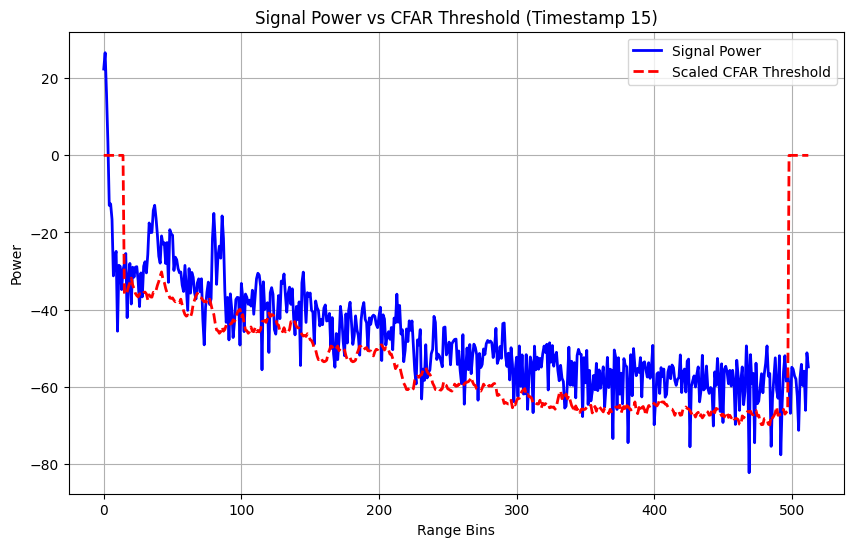

In [124]:
def plot_signal_power_vs_scaled_threshold_for_timestamp(signal_power, timestamp_index, num_training=10, num_guard=5, base_threshold=10, range_factor=1.5, x_bins=50):
    """
    Plots signal power and range-scaled CFAR threshold across range bins for a singular timestamp.

    Parameters:
    signal_power (np.ndarray): The signal power data (time x range bins).
    timestamp_index (int): The index of the timestamp to plot.
    num_training (int): Number of training cells on each side.
    num_guard (int): Number of guard cells on each side.
    base_threshold (float): Base threshold in dBm.
    range_factor (float): Factor to increase the threshold for lower range bins.
    x_bins (int): Number of range bins to apply the increased threshold.
    """
    # Extract signal power for the specific timestamp (across all range bins)
    signal_power_time = signal_power[timestamp_index, :]
    
    # Initialize an array to store the calculated threshold for each range bin
    calculated_threshold = np.zeros(signal_power_time.shape)
    
    # Calculate the threshold for each range bin
    num_bins = len(signal_power_time)
    for i in range(num_training + num_guard, num_bins - (num_training + num_guard)):
        if i < x_bins:
            # Apply range-dependent scaling for the first 'x_bins' bins
            range_scaled_threshold = base_threshold + range_factor / (i + 1)
            threshold_linear = 10**(range_scaled_threshold / 10)
        else:
            # Use base threshold for bins after 'x_bins'
            threshold_linear = 10**(base_threshold / 10)
        
        # Calculate the noise level using leading and lagging training cells
        leading_noise = np.sum(signal_power_time[i - num_training - num_guard : i - num_guard])
        lagging_noise = np.sum(signal_power_time[i + num_guard + 1 : i + num_guard + 1 + num_training])
        
        # Use the smallest noise estimate
        total_noise = min(leading_noise, lagging_noise) / num_training
        
        # Store the calculated threshold
        calculated_threshold[i] = total_noise * threshold_linear
    
    # Plot Signal Power vs. Scaled Threshold for the selected timestamp
    plt.figure(figsize=(10, 6))
    plt.plot(signal_power_time, label='Signal Power', color='blue', lw=2)
    plt.plot(calculated_threshold, label='Scaled CFAR Threshold', color='red', lw=2, linestyle='--')
    
    plt.title(f'Signal Power vs CFAR Threshold (Timestamp {timestamp_index})')
    plt.xlabel('Range Bins')
    plt.ylabel('Power')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
timestamp_index = 15  # The timestamp you want to analyze

# Assuming I1_data is (224, 512) for time samples and range bins
I1_data = fd_data[:, :, 0]  # Extract I1 signal from fd_data

# Plot signal power vs range-scaled threshold for a single timestamp across range bins
plot_signal_power_vs_scaled_threshold_for_timestamp(I1_data, timestamp_index, num_training=10, num_guard=5, base_threshold=0.5, range_factor=1.5, x_bins=50)



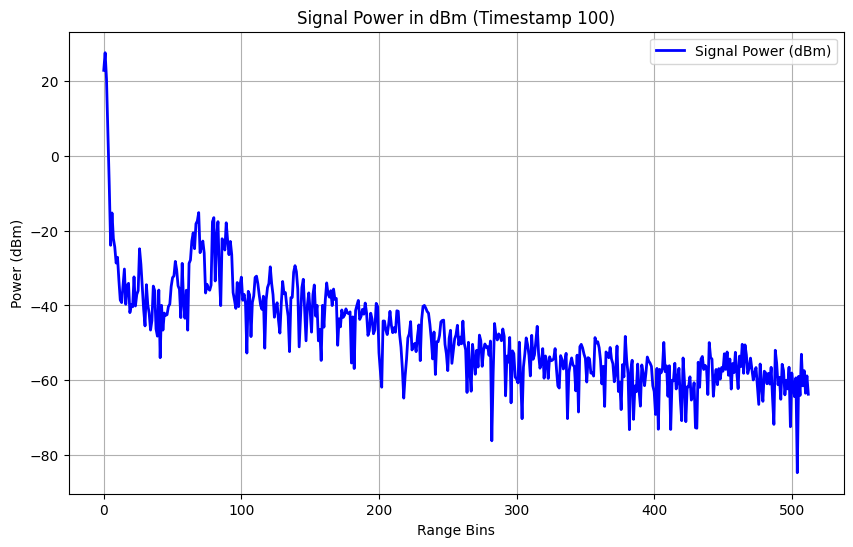

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def plot_signal_in_dBm(signal_power, timestamp_index):
    """
    Plots signal power in dBm across range bins for a singular timestamp.

    Parameters:
    signal_power (np.ndarray): The signal power data (time x range bins), assumed to be in dBm.
    timestamp_index (int): The index of the timestamp to plot.
    """
    # Extract signal power for the specific timestamp (across all range bins)
    signal_power_time = signal_power[timestamp_index, :]
    
    # Plot Signal Power in dBm for the selected timestamp
    plt.figure(figsize=(10, 6))
    plt.plot(signal_power_time, label='Signal Power (dBm)', color='blue', lw=2)
    
    plt.title(f'Signal Power in dBm (Timestamp {timestamp_index})')
    plt.xlabel('Range Bins')
    plt.ylabel('Power (dBm)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
timestamp_index = 100  # The timestamp you want to analyze

# Assuming I1_data is (224, 512) and already in dBm
I1_data = fd_data[:, :, 0]  # Extract I1 signal in dBm

# Plot signal power in dBm for a single timestamp across range bins
plot_signal_in_dBm(I1_data, timestamp_index)
